In [1]:
import datetime
import os
import geopandas
import glob
import pickle
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid')
from statsmodels.tsa.seasonal import STL
import urllib.request as req
import zipfile

## Question 1: Initial Fact Finding and Setup

### Describe your process for getting acquainted with the NYC TLC data and background information

My first steps were to read over the entirety of the Written Assignment document, so that I could go into my initial exploration knowing what sorts of things to be looking for. Then I went to the NYC TLC webpage provided to try to get a sense for how I would programmatically get the data. Specifically I was looking at the structure of the page, and what the urls for the datasets looked like. Then I downloaded one month of data so that I could look at the data and get a sense for how various columns were being used, and what to look for when ensuring that each column appears in the pandas DataFrame correctly. In addition, I had a look at the plots required in Question 4 and when I found things that I was uncertain about I searched for information. As a result, due to my discomfort with Choropleths in R, the language I tried them in most recently, I looked for how to handle them in Python. I found a good tutorial on Choropleths on Towards Data Science and found them to be much more straight-forward. In addition, I did a small literature review around Trip Flows, where I found an interesting paper out of Clemson University which explained the four-step model for Trip Flow analysis. In addition that paper presented the various other methods being used for Trip Flow Modelling

### What key considerations do you need to be mindful of prior to beginning the analysis

There are a few key considerations that immediately come to mind. Firstly, due to the component of the analysis that is centred around time series analysis, the data's seasonality and stationarity are important to consider. These measures facilitate any forcasting that might be done on the data. In addition to those, there is the matter of the geospatial component of this analysis. It can be difficult to visualize geospatial data, so considering how to go about that is important. Further to that there is key research question "What impact has COVID had on these trends?", a key consideration is how to communicate the significance of the findings with regard to that question. Lastly, keeping detailed notes of the data cleaning needs is also important.

### What relevant datasets and resources from the website do you plan to use?

Regarding the datasets and resources from the website that I plan to use. I will be using the requested csv datasets: 2018-06 - 2020-06 trip data csv datasets, as well as the Green Trips data dictionary, the Taxi Zone lookup table, and the Taxi Zone shape file.

### What relevent R or Python libraries and/or packages do you plan to use in your analysis

I plan to use urllib to query the page for the data that I will need to perform the analysis. I will be using the os package to handle filepaths. I have imported pickle so that I can store the DataFrame object as a stand-alone file, for ease of reloading everything. I will be using pandas, and seaborn to manipulate and visualize the data. Lastly, I will be using the statsmodels.tsa module's adfuller, and STL functions to facilitate stationarity and seasonality assessment for the time series analysis.

In [2]:
def get_data():
    """Gets the data for the Analysis either from the data.pkl file, or by making requests of the NYC TLC Page.
    Then calls the parse method to create the DataFrame."""
    data_filepath = os.getcwd()
    if os.path.exists(os.path.join(data_filepath, 'data.pkl')):
        df = pickle.load(open(os.path.join(data_filepath, 'data.pkl'), 'rb'))
    else:
        months = ['2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
                 '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
                 '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
                 '2020-03', '2020-04', '2020-05', '2020-06']
        data = None
        for month in months:
            filename = f'green_tripdata_{month}.csv'
            outfile = open(filename, 'wb')
            url = f'https://s3.amazonaws.com/nyc-tlc/trip+data/{filename}'
            page_data = req.urlopen(url)
            page_data = page_data.read()
            outfile.write(page_data)
            outfile.close()

        outfile = open('lookup_table.csv', 'wb')
        url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv'
        outfile.write(req.urlopen(url).read())

        outfile = open('shape_file.zip', 'wb')
        url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
        outfile.write(req.urlopen(url).read())
        with zipfile.ZipFile('shape_file.zip', 'r') as zip_ref:
            zip_ref.extractall(os.path.join(os.getcwd(), "map"))
        df = parse()
    return df

def parse():
    """Combines the csv files then performs some wrangling and cleaning tasks."""
    all_files = glob.glob(os.path.join(os.getcwd(), '*.csv'))
    condition_name = os.path.join(os.getcwd(), 'green_tripdata')
    dfs = []
    # reads each of the csv files into a dataframe then drops the columns that won't be used, and fills na in the categorical
    # features with -1
    for file in all_files:
        if not file.startswith(condition_name):
            continue
        temp = pd.read_csv(file)
        if 'congestion_surcharge' in list(temp):
            drop_cols = ['passenger_count', 'extra', 'mta_tax', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'congestion_surcharge']
        else:
            drop_cols = ['passenger_count', 'extra', 'mta_tax', 'tolls_amount', 'ehail_fee', 'improvement_surcharge']
        temp['lpep_pickup_datetime'] = pd.to_datetime(temp['lpep_pickup_datetime'])
        temp['lpep_dropoff_datetime'] = pd.to_datetime(temp['lpep_dropoff_datetime'])
        temp['VendorID'].fillna(-1, inplace=True)
        temp['store_and_fwd_flag'].fillna(-1, inplace=True)
        temp['RatecodeID'].fillna(-1, inplace=True)
        temp['PULocationID'].fillna(-1, inplace=True)
        temp['DOLocationID'].fillna(-1, inplace=True)
        temp['payment_type'].fillna(-1, inplace=True)
        temp['trip_type'].fillna(-1, inplace=True)
        
        
        temp.drop(drop_cols, axis=1, inplace=True)
        temp = temp.astype({
            'VendorID': 'int32',
            'store_and_fwd_flag': 'string',
            'RatecodeID': 'int32',
            'PULocationID': 'int32',
            'DOLocationID': 'int32',
            'trip_distance': 'float32',
            'fare_amount': 'float32',
            'tip_amount': 'float32',
            'total_amount': 'float32',
            'payment_type': 'int32',
            'trip_type':'int32'
        })

        print(f'{file} done')
        dfs.append(temp)
        
    df = pd.concat(dfs)
    # ensuring the typing from the previous step is maintained
    df['VendorID'].fillna(-1, inplace=True)
    df['store_and_fwd_flag'].fillna(-1, inplace=True)
    df['RatecodeID'].fillna(-1, inplace=True)
    df['PULocationID'].fillna(-1, inplace=True)
    df['DOLocationID'].fillna(-1, inplace=True)
    df['payment_type'].fillna(-1, inplace=True)
    df['trip_type'].fillna(-1, inplace=True)
    df = df.astype({
            'VendorID': 'int32',
            'store_and_fwd_flag': 'string',
            'RatecodeID': 'int32',
            'PULocationID': 'int32',
            'DOLocationID': 'int32',
            'trip_distance': 'float32',
            'fare_amount': 'float32',
            'tip_amount': 'float32',
            'total_amount': 'float32',
            'payment_type': 'int32',
            'trip_type':'int32'
            })
    # loads the luckup date and merges it into the data frame for both the pickup and dropoff locations
    lookup_data = pd.read_csv('lookup_table.csv')
    lookup_data['LocationID'] = lookup_data['LocationID'].astype('category')
    lookup_data['Borough'] = lookup_data['Borough'].astype('string')
    lookup_data['Zone'] = lookup_data['Zone'].astype('string')
    lookup_data['service_zone'] = lookup_data['service_zone'].astype('string')
    df = pd.merge(df, lookup_data, left_on='PULocationID', right_on='LocationID', suffixes=('_x', '_pickup'))
    df = pd.merge(df, lookup_data, left_on='DOLocationID', right_on='LocationID', suffixes=('_x', '_dropoff'))
    # sets the values of the categorical features to to the strings that they represent from the Data Dictionary
    df.loc[df['VendorID'] == 1, 'VendorID'] = 'Creative Mobile Technologies'
    df.loc[df['VendorID'] == 2, 'VendorID'] = 'Verifone Inc.'
    df.loc[df['VendorID'] == -1, 'VendorID'] = 'No Data'
    df.loc[df['store_and_fwd_flag'] == 'N' , 'store_and_fwd_flag'] = "No"
    df.loc[df['store_and_fwd_flag'] == 'Y' , 'store_and_fwd_flag'] = "Yes"
    df.loc[df['store_and_fwd_flag'] == '-1' , 'store_and_fwd_flag'] = "No Data"
    df.loc[df['RatecodeID'] == 1, 'RatecodeID'] = "Standard Rate"
    df.loc[df['RatecodeID'] == 2, 'RatecodeID'] = "JFk"
    df.loc[df['RatecodeID'] == 3, 'RatecodeID'] = "Newark"
    df.loc[df['RatecodeID'] == 4, 'RatecodeID'] = "Nassau or Winchester"
    df.loc[df['RatecodeID'] == 5, 'RatecodeID'] = "Negotiated Fare"
    df.loc[df['RatecodeID'] == 6, 'RatecodeID'] = "Group Ride"
    df.loc[df['RatecodeID'] == -1, 'RatecodeID'] = "No Data"
    df.loc[df['payment_type'] == 1, 'payment_type'] = 'Credit Card'
    df.loc[df['payment_type'] == 2, 'payment_type'] = 'Cash'
    df.loc[df['payment_type'] == 3, 'payment_type'] = 'No Charge'
    df.loc[df['payment_type'] == 4, 'payment_type'] = 'Dispute'
    df.loc[df['payment_type'] == 5, 'payment_type'] = 'Unknown'
    df.loc[df['payment_type'] == 6, 'payment_type'] = 'Voided Trip'
    df.loc[df['payment_type'] == -1, 'payment_type'] = 'No Data'
    df.loc[df['trip_type'] == 1, 'trip_type'] = 'Street-hail'
    df.loc[df['trip_type'] == 2, 'trip_type'] = 'Dispatched'
    df.loc[df['trip_type'] == -1, 'trip_type'] = 'No Data'
    
    
    # Sets the dtype of the columns to categorical
    df['VendorID'] = df['VendorID'].astype('category')
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
    df['RatecodeID'] = df['RatecodeID'].astype('category')
    df['PULocationID'] = df['PULocationID'].astype('category')
    df['DOLocationID'] = df['DOLocationID'].astype('category')
    df['payment_type'] = df['payment_type'].astype('category')
    df['Borough_x'] = df['Borough_x'].astype('category')
    df['Zone_x'] = df['Zone_x'].astype('category')
    df['Borough_dropoff'] = df['Borough_dropoff'].astype('category')
    df['Zone_dropoff'] = df['Zone_dropoff'].astype('category')
    df['trip_type'] = df['trip_type'].astype('category')
    # Drops some last minute unused columns to decrease the size in memory a bit more
    drops = ['PULocationID', 'DOLocationID', 'service_zone_dropoff', 'service_zone_x', 'LocationID_x', 'LocationID_dropoff']
    df.drop(drops, axis=1, inplace=True)
    df.info()
    
    pickle.dump(df, open('data.pkl', 'wb'))
    return df

def interpolate_negative_values(value_dict, origin, destination, feature):
    try:
        return_value = abs(value_dict[(origin, destination)][feature])
        return return_value
    except KeyError:
        return np.nan

In [3]:
df = get_data()

## Questions 2 and 3

I approached these two questions together, by writing a function which downloaded all of the relevant files then parsed them into a dataset which is usable. Due to some of the issues that I ran into while combining the trip datasets together, I decided that doing the data wrangling, and cleaning together would make it a bit more managable for me.

### Challenges
#### The dataset was quite large

Due to the size of the data set I had to take measures to decrease the dataset's size in memory. This is what lead to the decision to do components of the cleaning together. In order to decrease the size of the data. The first thing that I looked at was the dtypes of all of the features in the DataFrame, then I set the features with dtype "Object" to the dtype which most closely resembled the data found in the csv file. Converting the two datetime columns to datetime objects, and "store_and_fwd_flag" to a string. Further to that, I found that the floats, and itegers found in the data did not need to be stored as 64 bit integers or floats, so I scaled them down to their 32 bit forms. This decreased the size of the resultant dataset significantly. 

I then did the same for the lookup data before joining them. 

#### NaNs 

Due to the NaNs that were found in the data I wasn't able to set the various ID columns to 'int32' as I wanted to. So I filled them with -1 to mark the places where there was no data. This lead to me wanting to set the value of the ids to the value found in the Data Dictionary.

#### Differing columns in the datasets

There was one column which appears in only one of the datasets and needed to be dropped. So, I wrote an if statement to catch it and passed a version of the list of columns to drop that included the feature to be dropped.



### Feature Distributions

In [4]:
plotting_sample = df.sample(n=15000, random_state=2203)
plotting_sample.describe(include='all', datetime_is_numeric=True)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
count,15000,15000,15000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000,15000,15000,14993,15000,14962
unique,3,NaN,NaN,3,6,NaN,NaN,NaN,NaN,5,3,6,216,7,242
top,Verifone Inc.,NaN,NaN,No,Standard Rate,NaN,NaN,NaN,NaN,Credit Card,Street-hail,Manhattan,East Harlem North,Manhattan,East Harlem North
freq,11916,NaN,NaN,14091,13500,NaN,NaN,NaN,NaN,8125,13548,5072,1091,5676,570
mean,NaN,2019-03-25 01:40:01.125933824,2019-03-25 02:02:50.827659008,NaN,NaN,3.399217,14.461319,0.966136,17.091158,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2018-06-01 00:58:49,2018-06-01 01:10:32,NaN,NaN,-18.080000,-71.349998,-0.660000,-68.099998,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2018-10-09 15:50:45.249999872,2018-10-09 16:07:42,NaN,NaN,1.060000,6.500000,0.000000,8.300000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2019-02-27 23:05:41.500000,2019-02-27 23:11:55.500000,NaN,NaN,1.980000,10.500000,0.000000,12.550000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2019-09-04 08:54:58.750000128,2019-09-04 09:16:11.750000128,NaN,NaN,4.010000,18.000000,1.650000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2020-06-30 09:19:00,2020-06-30 09:36:00,NaN,NaN,112.949997,523.500000,25.520000,524.299988,NaN,NaN,NaN,NaN,NaN,NaN


Due to the way that Seaborn handles plotting histograms, I have taken a random sample of the data with an n of 15,000. Because it should be a large enough sample set to keep the general trends found in the data while still being small enough that I don't use all of my RAM.

The first thing that jumps out at me when I am looking at the baove table is that all of the numeric features include negative numbers. I will be exploring this later. Other things which jump out at me as needing cleaning, are the min dates being in the year 2008, and the max dates being in the year 2062.

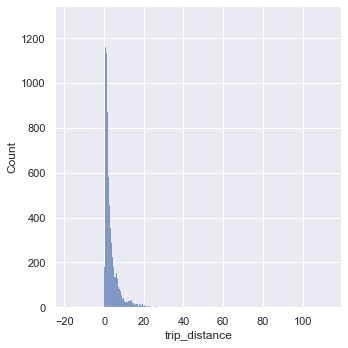

In [5]:
sns.displot(data=plotting_sample, x="trip_distance", kde=False)
plt.show()

The above histogram for trip_distance, shows a long tail distribution. But it is hard to see why the axes are set as they are. So I plotted the graph again with the y axis set to show a log scale. I did the same for all of the other histograms.

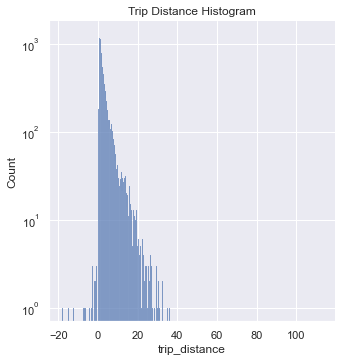

In [6]:
plot = sns.displot(data=plotting_sample, x="trip_distance", kde=False)
plot.fig.get_axes()[0].set_yscale('log')
plt.title("Trip Distance Histogram")
plt.show()

<Figure size 432x288 with 0 Axes>

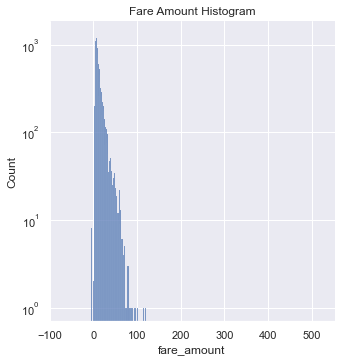

In [7]:
plt.figure()
plot = sns.displot(data=plotting_sample, x='fare_amount')
plot.fig.get_axes()[0].set_yscale('log')
plt.title("Fare Amount Histogram")
plt.show()

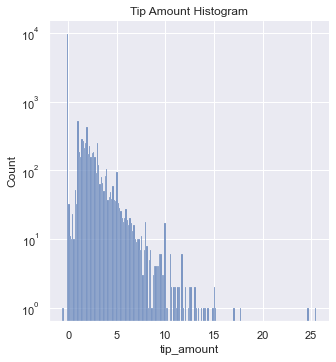

In [8]:
plot = sns.displot(data=plotting_sample, x="tip_amount")
plot.fig.get_axes()[0].set_yscale('log')
plt.title("Tip Amount Histogram")
plt.show()

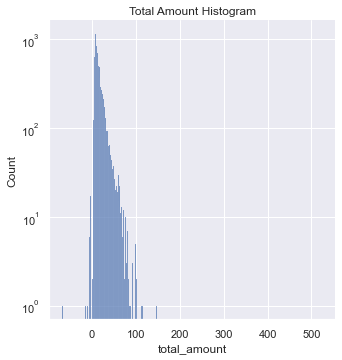

In [9]:
plot = sns.displot(data=plotting_sample, x="total_amount")
plot.fig.get_axes()[0].set_yscale('log')
plt.title('Total Amount Histogram')
plt.show()

#### Exploration of the Anomalous Values in the Numeric Features

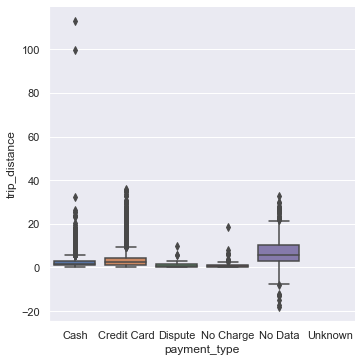

In [10]:
sns.catplot(x="payment_type", y="trip_distance", kind="box", data=plotting_sample)
plt.show()

I thought to find that trip distance would be negative when the payment type was "Voided Trip" I did not find that to be the case. I will explore them more later. 

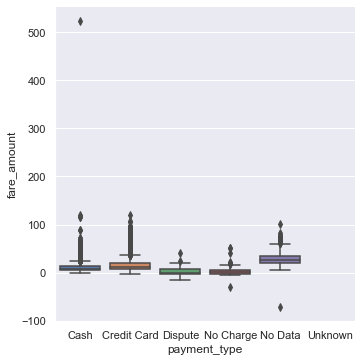

In [11]:
sns.catplot(x="payment_type", y="fare_amount", kind="box", data=plotting_sample)
plt.show()

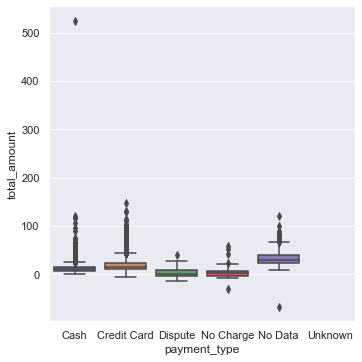

In [12]:
sns.catplot(x="payment_type", y="total_amount", kind="box", data=plotting_sample)
plt.show()

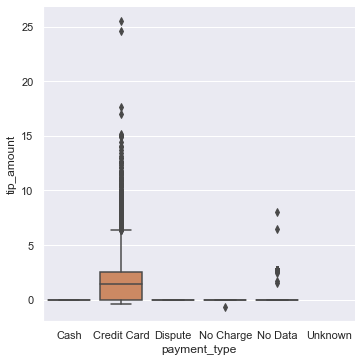

In [13]:
sns.catplot(x="payment_type", y="tip_amount", kind="box", data=plotting_sample)
plt.show()

The negative monetary amounts are confusing me. The sample that I got in my initial look showed the majority of them being associated with Disputes and No Charge payment types. This sample is showing different places for these negative numbers to show up. 

#### Exploration of the Anomalous values in the Trip Distance

In [14]:
exploration_data = df.loc[df['trip_distance']<0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

exploration_data.describe()

,trip_distance,fare_amount,tip_amount,total_amount
count,19487.000000,19487.000000,19487.000000,19487.000000
mean,-10.391512,28.653269,0.003439,33.200722
std,223.566284,12.111329,0.100554,13.210863
min,-20329.080078,-48.599998,0.000000,-42.299999
25%,-10.360000,19.559999,0.000000,23.389999
50%,-5.380000,25.420000,0.000000,29.209999
75%,-2.620000,36.000000,0.000000,41.320000
max,-0.010000,82.180000,9.180000,91.389999


It seems like there was a period between 23 October 2019 and 15 Jan 2020 where the negative trip distances appear. To resolve this I created a dataframe which has the origin and destination values and a mean of the distance for trips with those endpoints. I found that after taking the median of the trip distances there were still 199 O-D enpoints with negative values. I had a look at the way that they were distributed. And compared them aginst distances for those areas as reported by google maps, they appear to be similar to the distances so I had the method return the absolute value instead of the negative value. This might have knock on effects when doing any distance related modelling. However, based on my initial explorations it seems like a reasonable assumption.

In [15]:
distance_interpolation = df.groupby(['Zone_x', 'Zone_dropoff']).agg({'trip_distance': 'median',
                                                                     'fare_amount': 'median',
                                                                     'tip_amount': 'median',
                                                                     'total_amount': 'median'}).copy()

distance_interpolation.loc[distance_interpolation['trip_distance'] < 0]

trip_distance  fare_amount  \
Zone_x             Zone_dropoff                                            
Alphabet City      Astoria                          -10.010    20.719999   
                   Briarwood/Jamaica Hills           -0.575    39.705002   
                   Bushwick North                    -5.830    23.559999   
                   Crown Heights South               -7.350    27.760000   
                   Jamaica                          -13.590    45.790001   
...                                                     ...          ...   
World Trade Center Queensbridge/Ravenswood           -9.000    28.879999   
                   Washington Heights South          -5.500    48.495003   
                   Williamsburg (South Side)         -4.450    24.700001   
Yorkville East     West Concourse                    -4.330    26.174999   
Yorkville West     Cypress Hills                    -17.430    30.090000   

                                              tip_amount  total_amount  
Zone_x             Zone_dropoff                                         
Alphabet City      Astoria                           0.0     27.020000  
                   Briarwood/Jamaica Hills           0.0     47.689999  
                   Bushwick North                    0.0     27.110001  
                   Crown Heights South               0.0     31.309999  
                   Jamaica                           0.0     55.459999  
...                                                  ...           ...  
World Trade Center Queensbridge/Ravenswood           0.0     35.180000  
                   Washington Heights South          0.0     50.669998  
                   Williamsburg (South Side)         0.0     28.250000  
Yorkville East     West Concourse                    0.0     29.725002  
Yorkville West     Cypress Hills                     0.0     39.759998  

[199 rows x 4 columns]

In [16]:
df.loc[(df['Zone_x']=="Lower East Side") & (df['Zone_dropoff'] =='Kingsbridge Heights'), ]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
11841621,No Data,2019-09-24 10:59:59,2019-09-24 11:39:19,-1,No Data,13.4,54.250000,0.0,57.299999,No Data,No Data,Manhattan,Lower East Side,Bronx,Kingsbridge Heights
11841622,No Data,2019-11-14 19:18:00,2019-11-14 19:56:00,-1,No Data,0.0,-56.060001,0.0,-52.509998,No Data,No Data,Manhattan,Lower East Side,Bronx,Kingsbridge Heights


In [17]:
difference = abs(df.iloc[11841622]['fare_amount']) - abs(df.iloc[11841622]['total_amount'])
df.loc[11841622, ['trip_distance']] = df.iloc[11841621]['trip_distance']
df.loc[11841622, ['fare_amount']] = abs(df.iloc[11841622]['fare_amount'])
df.loc[11841622, ['total_amount']] = df.iloc[11841622]['fare_amount'] + difference

I also found fare amounts which were negative. So, I had a look at them and since there were only four decided to explore each of them and fix them. I changed the trip distance in the above to match the only other one with the same endpoints. I don't see this particular change affecting on going analyses. the difference in total price is only a couple of dollars.

Below I continue to do the same with the other three

In [18]:
df.loc[(df['Zone_x']=="Gramercy") & (df['Zone_dropoff'] =='Fordham South'), ]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
11771700,No Data,2020-01-17 16:18:00,2020-01-17 17:24:00,-1,No Data,10.79,-57.650002,0.0,-54.599998,No Data,No Data,Manhattan,Gramercy,Bronx,Fordham South


In [19]:
difference = abs(df.iloc[11771700]['fare_amount']) - abs(df.iloc[11771700]['total_amount'])
df.loc[11771700, ['fare_amount']] = abs(df.iloc[11771700]['fare_amount'])
df.loc[11771700, ['total_amount']] = df.iloc[11771700]['fare_amount'] + difference

In [20]:
df.loc[(df['Zone_x']=="Grymes Hill/Clifton") & (df['Zone_dropoff'] =='Times Sq/Theatre District'), ]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
2115498,No Data,2020-02-05 11:27:00,2020-02-05 12:32:00,-1,No Data,19.98,-94.910004,0.0,-73.5,No Data,No Data,Staten Island,Grymes Hill/Clifton,Manhattan,Times Sq/Theatre District


In [21]:
difference = abs(df.iloc[2115498]['fare_amount']) - abs(df.iloc[2115498]['total_amount'])
df.loc[2115498, ['fare_amount']] = abs(df.iloc[2115498]['fare_amount'])
df.loc[2115498, ['total_amount']] = df.iloc[2115498]['fare_amount'] + difference

In [22]:
df.loc[(df['Zone_x']=="Meatpacking/West Village West") & (df['Zone_dropoff'] =='Jackson Heights'), ]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
7615504,No Data,2019-11-09 09:49:00,2019-11-09 10:18:00,-1,No Data,9.11,-41.950001,0.0,-38.400002,No Data,No Data,Manhattan,Meatpacking/West Village West,Queens,Jackson Heights


In [23]:
difference = abs(df.iloc[7615504]['fare_amount']) - abs(df.iloc[7615504]['total_amount'])
df.loc[7615504, ['fare_amount']] = abs(df.iloc[7615504]['fare_amount'])
df.loc[7615504, ['total_amount']] = df.iloc[7615504]['fare_amount'] + difference

These three are stand alone trips, and the values look reasonable. I have applied the same approach as above to the fare amount and total amount.

In [24]:
distance_interpolation = df.groupby(['Zone_x', 'Zone_dropoff']).agg({'trip_distance': 'median',
                                                                     'fare_amount': 'median',
                                                                     'tip_amount': 'median',
                                                                     'total_amount': 'median'}).copy()
interpolation = distance_interpolation.to_dict(orient='index')

In [25]:
exploration_data['trip_distance'] = exploration_data.apply(lambda row: interpolate_negative_values(interpolation, 
                                                                row['Zone_x'], 
                                                                row['Zone_dropoff'],
                                                               'trip_distance'), axis=1)
df.update(exploration_data)
df.loc[df['trip_distance'] < 0,]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,Borough_x,Zone_x,Borough_dropoff,Zone_dropoff
1643527,No Data,2019-12-16 17:23:00,2019-12-16 18:24:00,-1,No Data,-13.100000,59.560001,0.0,65.860001,No Data,No Data,Unknown,<NA>,Brooklyn,Stuyvesant Heights
3126084,No Data,2019-11-20 17:14:00,2019-11-20 17:53:00,-1,No Data,-8.510000,39.660000,0.0,43.209999,No Data,No Data,Unknown,<NA>,Queens,Jamaica
3126088,No Data,2019-12-05 18:23:00,2019-12-05 18:57:00,-1,No Data,-7.300000,39.660000,0.0,43.209999,No Data,No Data,Unknown,<NA>,Queens,Jamaica
4476813,No Data,2019-11-26 06:02:00,2019-11-26 07:04:00,-1,No Data,-21.350000,52.209999,0.0,61.880001,No Data,No Data,Unknown,<NA>,Manhattan,Upper West Side North
4585021,No Data,2019-11-25 06:05:00,2019-11-25 07:08:00,-1,No Data,-21.110001,52.209999,0.0,61.880001,No Data,No Data,Unknown,<NA>,Manhattan,Upper West Side South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11856034,No Data,2019-12-09 08:23:00,2019-12-09 08:51:00,-1,No Data,-4.970000,30.660000,0.0,34.209999,No Data,No Data,Unknown,<NA>,Bronx,Van Cortlandt Village
11856035,No Data,2019-12-12 15:06:00,2019-12-12 15:56:00,-1,No Data,-18.780001,48.770000,0.0,58.439999,No Data,No Data,Unknown,<NA>,Bronx,Van Cortlandt Village
11931404,No Data,2019-12-14 13:12:00,2019-12-14 13:48:00,-1,No Data,-12.280000,48.770000,0.0,58.439999,No Data,No Data,Unknown,<NA>,Queens,Bay Terrace/Fort Totten
11978034,No Data,2019-11-24 11:43:00,2019-11-24 12:22:00,-1,No Data,-19.200001,48.770000,0.0,58.439999,No Data,No Data,Unknown,<NA>,Bronx,East Tremont


There are still 112 trips with negative trip distances. I am going to drop all of the rows with unknown pick up or drop off burrows.

In [26]:
df = df.loc[df['Borough_x'] != 'Unknown', ].copy()
df = df.loc[df['Borough_dropoff'] != 'Unknown', ].copy()

#### Handling Trip Distances with value 0

In [27]:
exploration_data = df.loc[df['trip_distance']==0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

exploration_data.describe()

,trip_distance,fare_amount,tip_amount,total_amount
count,208687.0,208687.000000,208687.000000,208687.000000
mean,0.0,15.919970,0.568458,17.581778
std,0.0,26.278803,3.944356,27.096766
min,0.0,-890.000000,-25.160000,-890.299988
25%,0.0,2.500000,0.000000,4.300000
50%,0.0,10.000000,0.000000,12.000000
75%,0.0,24.200001,0.000000,26.170000
max,0.0,4307.000000,485.549988,4307.799805


There are 208,687 trips with distance value of 0. I will apply the same methodology as above here as well. I know that there are about 744 endpoint pairs which have zero for their trip_distance. However, I am hoping that the same methodology will knock the number down a fair amount.

In [28]:
exploration_data['trip_distance'] = exploration_data.apply(lambda row: interpolate_negative_values(interpolation, 
                                                                row['Zone_x'], 
                                                                row['Zone_dropoff'],
                                                               'trip_distance'), axis=1)
df.update(exploration_data)

In [29]:
exploration_data = df.loc[df['trip_distance']==0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

exploration_data.describe()

,trip_distance,fare_amount,tip_amount,total_amount
count,18363.0,18363.000000,18363.000000,18363.000000
mean,0.0,9.951826,0.698452,11.462829
std,0.0,60.157894,4.312883,60.718765
min,0.0,-156.000000,-3.000000,-156.000000
25%,0.0,0.050000,0.000000,0.420000
50%,0.0,2.500000,0.000000,3.800000
75%,0.0,3.000000,0.000000,5.160000
max,0.0,4307.000000,350.299988,4307.799805


I managed to account for the vast majority of the zero value distances. Leaving just 18,363 to deal with.

#### Exploration of the negative monetary features

##### Fare amount Exploration

In [30]:
exploration_data = df.loc[df['fare_amount']<0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,35342,35342,35342.000000,35342.000000,35342.000000,35342.000000
mean,2019-03-27 09:04:25.129553664,2019-03-27 09:12:51.578993664,0.524804,-6.447011,-0.015829,-7.449285
min,2009-01-01 00:07:17,2009-01-01 01:28:23,0.000000,-890.000000,-90.500000,-890.299988
25%,2018-10-27 15:31:17.750000128,2018-10-27 15:55:11,0.100000,-5.000000,0.000000,-5.800000
50%,2019-03-02 19:12:56.500000,2019-03-02 19:21:41.500000,0.430000,-3.500000,0.000000,-4.800000
75%,2019-08-24 19:45:45.500000256,2019-08-24 20:35:11.499999744,0.690000,-2.500000,0.000000,-3.800000
max,2020-06-30 20:37:46,2020-06-30 20:39:52,34.580002,-0.010000,8.550000,32.900002
std,NaN,NaN,1.127427,12.944790,0.694275,12.729887


In [31]:
exploration_data['fare_amount'] = exploration_data.apply(lambda row: interpolate_negative_values(interpolation, 
                                                                row['Zone_x'], 
                                                                row['Zone_dropoff'],
                                                               'fare_amount'), axis=1)
df.update(exploration_data)

In [32]:
exploration_data = df.loc[df['fare_amount']<0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,0,0,0.0,0.0,0.0,0.0
mean,NaT,NaT,NaN,NaN,NaN,NaN
min,NaT,NaT,NaN,NaN,NaN,NaN
25%,NaT,NaT,NaN,NaN,NaN,NaN
50%,NaT,NaT,NaN,NaN,NaN,NaN
75%,NaT,NaT,NaN,NaN,NaN,NaN
max,NaT,NaT,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df.describe()

,trip_distance,fare_amount,tip_amount,total_amount
count,1.200628e+07,1.200628e+07,1.200628e+07,1.200628e+07
mean,3.940274e+00,1.436532e+01,9.882841e-01,1.710793e+01
std,2.342198e+02,1.265291e+01,1.897056e+00,1.383139e+01
min,0.000000e+00,0.000000e+00,-9.050000e+01,-8.903000e+02
25%,1.100000e+00,6.500000e+00,0.000000e+00,8.320000e+00
50%,2.010000e+00,1.050000e+01,0.000000e+00,1.247000e+01
75%,4.100000e+00,1.750000e+01,1.660000e+00,2.080000e+01
max,1.693303e+05,8.011500e+03,6.412000e+02,8.013300e+03


Now that I have gotten rid of all of the negative fare amounts. I think that I might need to look at the fare amounts with value 0

In [34]:
exploration_data = df.loc[df['fare_amount']== 0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,22562,22562,22562.000000,22562.0,22562.000000,22562.000000
mean,2019-04-26 20:17:38.554914048,2019-04-26 20:37:11.631421440,3.294948,0.0,0.186204,0.387024
min,2008-10-21 15:52:05,2008-10-21 15:54:26,0.000000,0.0,0.000000,0.000000
25%,2018-11-17 17:05:47.750000128,2018-11-17 17:06:15.500000,0.500000,0.0,0.000000,0.000000
50%,2019-04-26 10:49:06.500000,2019-04-26 11:01:33.500000,1.700000,0.0,0.000000,0.000000
75%,2019-10-16 15:32:51.250000128,2019-10-16 15:49:41.500000,4.100000,0.0,0.000000,0.000000
max,2035-09-02 17:17:47,2035-09-02 19:01:37,4566.439941,0.0,110.000000,160.000000
std,NaN,NaN,30.686745,0.0,2.592000,3.237389


In [35]:
exploration_data['fare_amount'] = exploration_data.apply(lambda row: interpolate_negative_values(interpolation, 
                                                                row['Zone_x'], 
                                                                row['Zone_dropoff'],
                                                               'fare_amount'), axis=1)
df.update(exploration_data)

In [36]:
exploration_data = df.loc[df['fare_amount']==0, ].copy()
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,64,64,64.000000,64.0,64.0,64.000000
mean,2019-03-29 07:02:00.156250112,2019-03-29 07:43:09.734374656,11.398125,0.0,0.0,2.030937
min,2018-06-05 07:38:17,2018-06-05 08:08:57,4.100000,0.0,0.0,0.000000
25%,2018-12-04 18:01:35.749999872,2018-12-04 19:28:47.749999872,8.550000,0.0,0.0,0.000000
50%,2019-03-01 07:37:52,2019-03-01 08:12:39,10.600000,0.0,0.0,0.000000
75%,2019-07-09 01:40:15.249999872,2019-07-09 07:22:39.250000128,11.100000,0.0,0.0,0.000000
max,2020-06-19 21:26:12,2020-06-19 22:26:49,37.900002,0.0,0.0,55.759998
std,NaN,NaN,6.360391,0.0,0.0,7.337656


Now that I have resolved the majority of the zero value fare amounts, I will drop the 64 remaining values.

One potential downstream effect of replacing these values would be the possibility of removing Disputed and No Charge negative values. However, the range of values also shows a significant number of records in the positive range for both of those payment types.

#### Exploration of the Date Features

<Figure size 432x288 with 0 Axes>

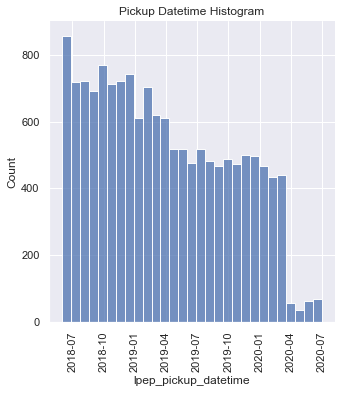

In [37]:
plt.figure()
plot = sns.displot(data=plotting_sample, x='lpep_pickup_datetime')
plot.set_xticklabels(rotation=90)
plt.title("Pickup Datetime Histogram")
plt.show()

<Figure size 432x288 with 0 Axes>

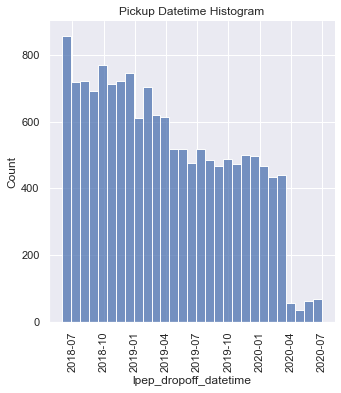

In [38]:
plt.figure()
plot = sns.displot(data=plotting_sample, x='lpep_dropoff_datetime')
plot.set_xticklabels(rotation=90)
plt.title("Pickup Datetime Histogram")
plt.show()

#### Handling the Anomalous Values in the DateTime Features

In [39]:
exploration_data = df.loc[df['lpep_pickup_datetime'] < pd.to_datetime('2018-06-01'), ]
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,377,377,377.000000,377.000000,377.000000,377.000000
mean,2010-05-19 04:16:54.694960384,2010-05-19 08:27:59.710874880,3.442361,14.249072,0.636631,15.983663
min,2008-10-21 15:52:05,2008-10-21 15:54:26,0.000000,2.500000,-1.140000,-7.800000
25%,2009-01-01 00:24:39,2009-01-01 01:02:25,0.960000,6.000000,0.000000,7.800000
50%,2009-01-01 05:03:33,2009-01-01 12:24:31,1.780000,9.500000,0.000000,10.800000
75%,2010-09-23 01:01:31,2010-09-23 12:21:08,4.250000,17.500000,0.000000,19.299999
max,2018-05-31 23:59:48,2018-06-01 19:08:04,34.080002,89.000000,20.000000,96.419998
std,NaN,NaN,4.315417,13.146542,1.968831,14.351753


There are very few data points with dates below the expected lower bound, when compared to the total number of datapoints in this dataset. I am going to remove the datapoints with pickup and dropoff dates earlier than 2018.

In [40]:
df = df.loc[df['lpep_pickup_datetime'] >= pd.to_datetime('2018-06-01'), ]

In [41]:
exploration_data = df.loc[df['lpep_pickup_datetime'] >= pd.to_datetime('2020-07-01', format='%Y-%m-%d'), ]
exploration_data.describe(datetime_is_numeric=True)

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,fare_amount,tip_amount,total_amount
count,6,6,6.000000,6.000000,6.0,6.000000
mean,2026-08-17 15:22:21.333333248,2026-08-17 15:45:50.166666496,1.533333,7.583333,0.0,8.033334
min,2020-07-14 04:48:19,2020-07-14 05:05:37,0.000000,2.500000,0.0,0.000000
25%,2020-11-14 10:21:13.750000128,2020-11-14 10:29:16,0.180000,4.625000,0.0,5.325000
50%,2025-11-21 05:56:28.500000,2025-11-21 05:58:38,0.855000,5.750000,0.0,6.800000
75%,2030-11-28 00:18:19.250000128,2030-11-28 00:22:56.250000128,3.015000,11.000000,0.0,12.550000
max,2035-09-02 17:17:47,2035-09-02 19:01:37,3.800000,14.500000,0.0,15.300000
std,NaN,NaN,1.748893,4.800174,0.0,5.819851


The dates above the expected range are even fewer than the dates below the expected range. I will be dropping them as well.

#### Potential Downstream effects

It is possible that by removing these date values I am removing valid trips which took place within the date range. However, as the total number of anomalous dates is tiny in comparison to the total number of records; I am comfortable removing them from the dataset.


In [42]:
df = df.loc[df['lpep_pickup_datetime'] < pd.to_datetime('2020-07-01', format='%Y-%m-%d'), ]

#### Exploration of the Categorical Features

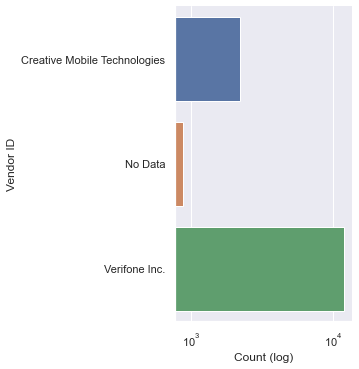

In [43]:
plot = sns.catplot(y='VendorID', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (log)')
plt.ylabel('Vendor ID')
plt.show()

The vast majority of the trips in this dataset have vendor "Verifone Inc". There are relatively few with no data.

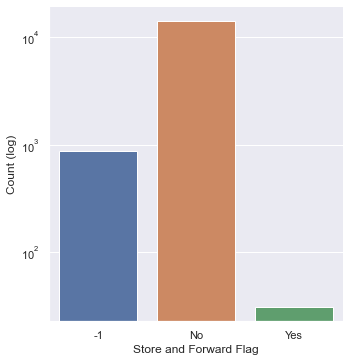

In [44]:
plot = sns.catplot(x='store_and_fwd_flag', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_yscale('log')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Count (log)')
plt.show()

The No Data column here is pretty significant. That seems strange to me.

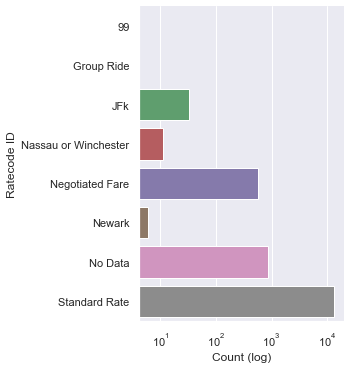

In [45]:
plot = sns.catplot(y='RatecodeID', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (log)')
plt.ylabel('Ratecode ID')
plt.show()

There is another thing to clean up. There is a ratecode 99 which doesn't appear in the data dictionary. It appears to represent a very small number of trips. So I will remove it. I don't expect this to effect the downstream analysis much.

In [46]:
df = df.loc[df['RatecodeID'] != 99, ]

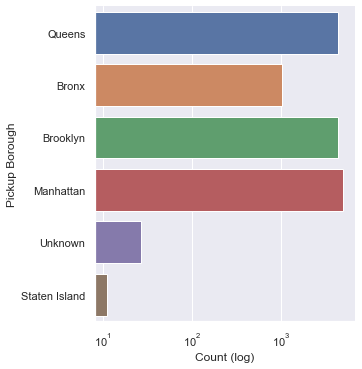

In [47]:
plot = sns.catplot(y='Borough_x', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (log)')
plt.ylabel('Pickup Borough')
plt.show()

It doesn't suprise me that Manhattan, Brooklyn, and Queens represent the most common pickup Boroughs in the data set. 

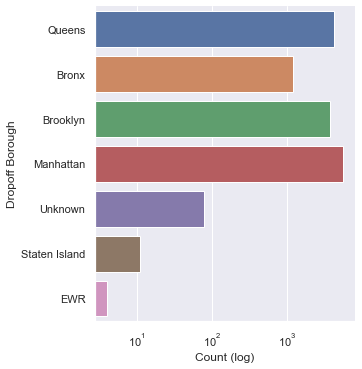

In [48]:
plot = sns.catplot(y='Borough_dropoff', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (log)')
plt.ylabel('Dropoff Borough')
plt.show()

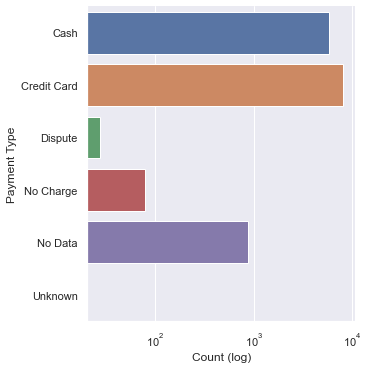

In [49]:
plot = sns.catplot(y='payment_type', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (log)')
plt.ylabel('Payment Type')
plt.show()

Again I am finding the number of trips without payment type data to be fairly interesting. But, nothing else seems that strange to me. There are very few Disputes and No Charge rides when compared to the Cash and Credit rides.

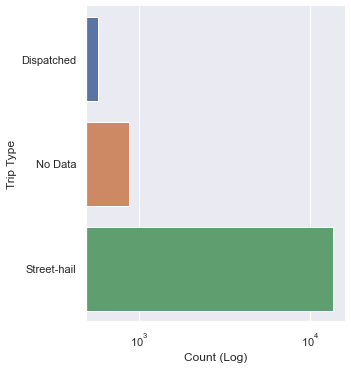

In [50]:
plot = sns.catplot(y='trip_type', kind='count', data=plotting_sample)
plot.fig.get_axes()[0].set_xscale('log')
plt.xlabel('Count (Log)')
plt.ylabel('Trip Type')
plt.show()

It seems reasonable to me that the vast majority of taxi rides in New York would be hailed on the street as opposed to dispatched through the switchboard.

## Question 4

### Pick-ups Time Series

#### Daily Pick-ups by Vendor

In [ ]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_pickup_datetime', freq='D'), 'VendorID']).agg({
    'RatecodeID': 'count'
})

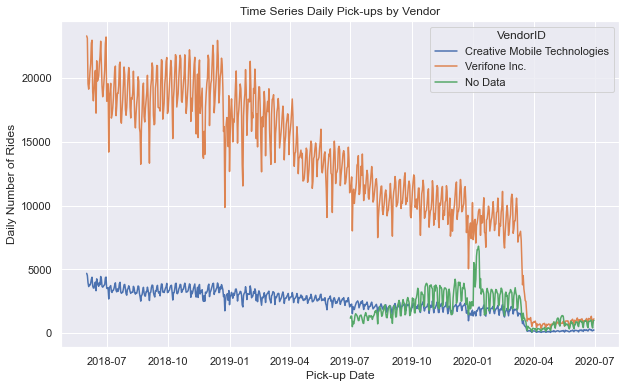

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=daily_pickups, hue='VendorID')
plt.title('Time Series Daily Pick-ups by Vendor')
plt.xlabel('Pick-up Date')
plt.ylabel('Daily Number of Rides')
plt.show()

The trends here are really quite clear. I wonder what is going on with the Trips with no data for the VendorID. 

#### Monthly Pick-ups by Vendor

In [53]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_pickup_datetime', freq='M'), 'VendorID']).agg({
    'RatecodeID': 'count'
})

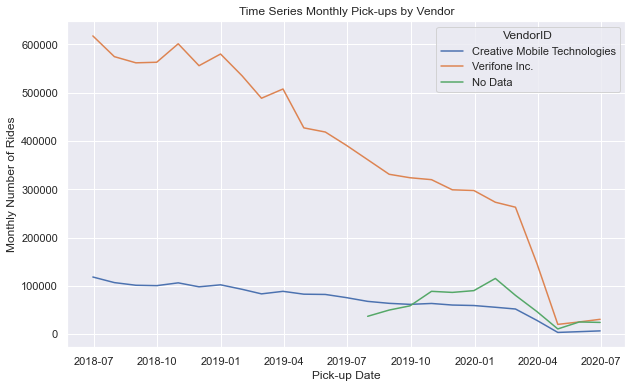

In [54]:
plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=daily_pickups, hue='VendorID')
plt.title('Time Series Monthly Pick-ups by Vendor')
plt.xlabel('Pick-up Date')
plt.ylabel('Monthly Number of Rides')
plt.show()

The monthly plots do make the trends easier to see.

#### Monthly Pick-ups by Borough

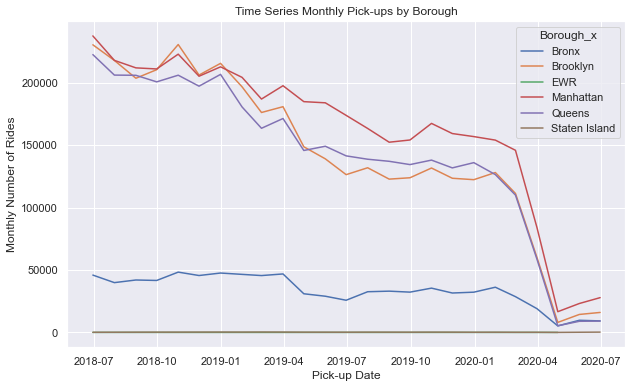

In [55]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_pickup_datetime', freq='M'), 'Borough_x']).agg({
    'RatecodeID': 'count'
})

plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=daily_pickups, hue='Borough_x')
plt.title('Time Series Monthly Pick-ups by Borough')
plt.xlabel('Pick-up Date')
plt.ylabel('Monthly Number of Rides')
plt.show()

### Drop-offs Time Series
#### Daily Drop-offs by Vendor

In [56]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_dropoff_datetime', freq='D'), 'VendorID']).agg({
    'RatecodeID': 'count'
})

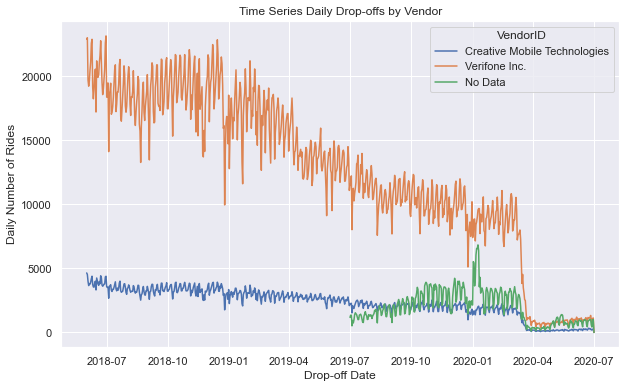

In [57]:
plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=daily_pickups, hue='VendorID')
plt.title('Time Series Daily Drop-offs by Vendor')
plt.xlabel('Drop-off Date')
plt.ylabel('Daily Number of Rides')
plt.show()

#### Monthly Drop-offs by Vendor

In [58]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_dropoff_datetime', freq='M'), 'VendorID']).agg({
    'RatecodeID': 'count'
})

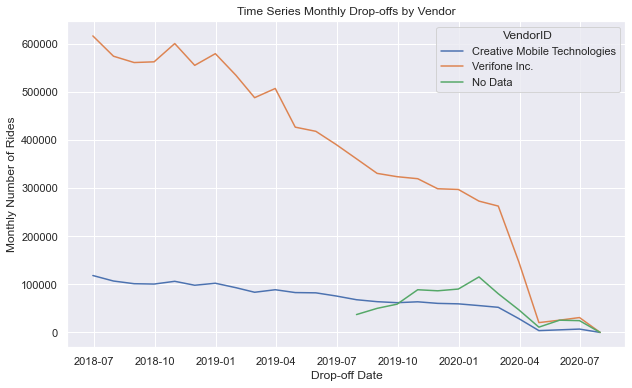

In [59]:
plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=daily_pickups, hue='VendorID')
plt.title('Time Series Monthly Drop-offs by Vendor')
plt.xlabel('Drop-off Date')
plt.ylabel('Monthly Number of Rides')
plt.show()

#### Monthly Drop-offs by Borough

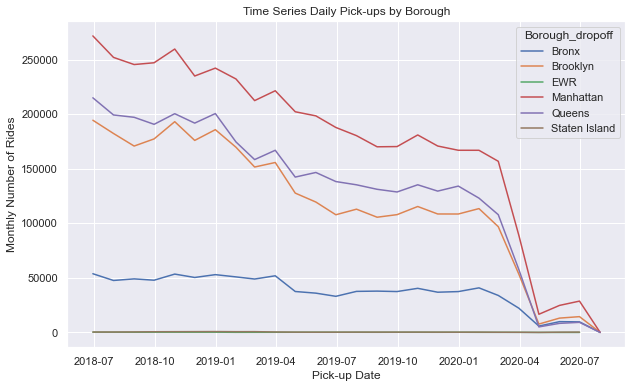

In [60]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby([pd.Grouper(key='lpep_dropoff_datetime', freq='M'), 'Borough_dropoff']).agg({
    'RatecodeID': 'count'
})

plt.figure(figsize=(10,6))
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=daily_pickups, hue='Borough_dropoff')
plt.title('Time Series Daily Pick-ups by Borough')
plt.xlabel('Pick-up Date')
plt.ylabel('Monthly Number of Rides')
plt.show()

### STL Decomposition of Aggregated Ride data
#### Pick-up Decomposition

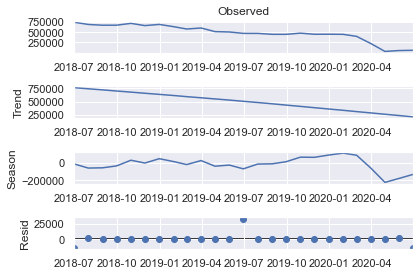

In [61]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby(pd.Grouper(key='lpep_pickup_datetime', freq='M')).agg({
    'RatecodeID': 'count'
})
res = STL(daily_pickups).fit()
res.plot()
plt.show()

#### Drop-offs Decomposition

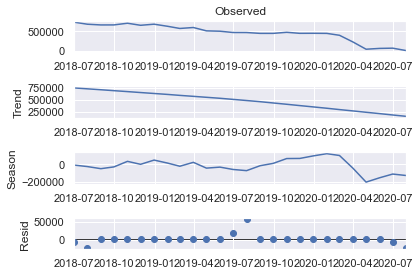

In [62]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.groupby(pd.Grouper(key='lpep_dropoff_datetime', freq='M')).agg({
    'RatecodeID': 'count'
})
res = STL(daily_pickups).fit()
res.plot()
plt.show()

While there appears to be some seasonality in the data it doesn't appear as regular as I expected that it might. The trendline is strongly negative throughout, with the COVID-19 lockdowns having a dramatic effect on the observed number of pick-ups and drop-offs

#### Decomposition by Borough

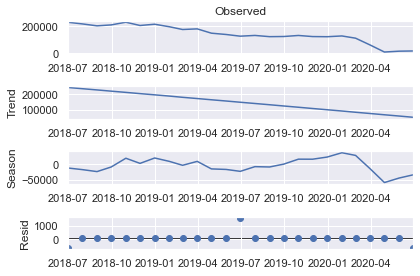

In [99]:
daily_pickups = df.loc[df['Borough_x'] == 'Brooklyn'].copy()
daily_pickups = daily_pickups.groupby(pd.Grouper(key='lpep_pickup_datetime', freq='M')).agg({
    'RatecodeID': 'count'
})
res = STL(daily_pickups).fit()
res.plot()
plt.show()

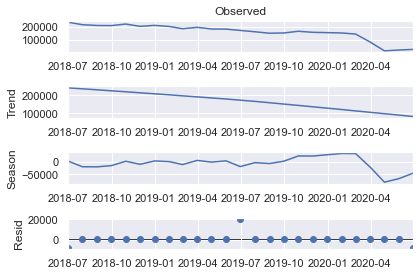

In [100]:
daily_pickups = df.loc[df['Borough_x'] == 'Manhattan'].copy()
daily_pickups = daily_pickups.groupby(pd.Grouper(key='lpep_pickup_datetime', freq='M')).agg({
    'RatecodeID': 'count'
})
res = STL(daily_pickups).fit()
res.plot()
plt.show()

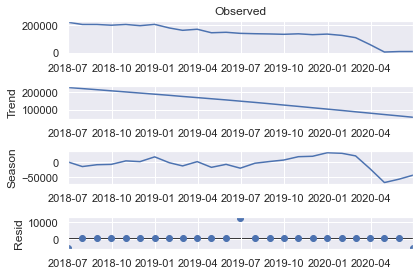

In [101]:
daily_pickups = df.loc[df['Borough_x'] == 'Queens'].copy()
daily_pickups = daily_pickups.groupby(pd.Grouper(key='lpep_pickup_datetime', freq='M')).agg({
    'RatecodeID': 'count'
})
res = STL(daily_pickups).fit()
res.plot()
plt.show()

#### Taxi Zone Pick-ups

In [63]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.pivot_table(index=pd.Grouper(key='lpep_pickup_datetime', freq='M'),
                                         columns='Borough_x', values='VendorID', aggfunc=np.count_nonzero)

daily_pickups.fillna(0, inplace=True)
daily_pickups.reset_index(inplace=True)
daily_pickups['lpep_pickup_datetime'] = daily_pickups['lpep_pickup_datetime'].dt.strftime('%d/%m/%Y')
daily_pickups.set_index('lpep_pickup_datetime', inplace=True)

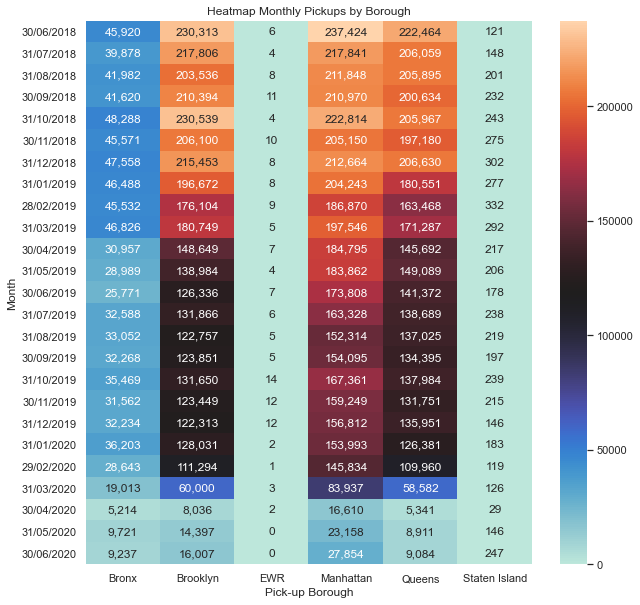

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(daily_pickups, annot=True, fmt=',.0f', cmap='icefire')
plt.title('Heatmap Monthly Pickups by Borough')
plt.xlabel('Pick-up Borough')
plt.ylabel('Month')
plt.show()

In [65]:
daily_pickups = df.loc[df['Borough_x'] == 'Manhattan', ].copy()
daily_pickups = daily_pickups.pivot_table(index=pd.Grouper(key='lpep_pickup_datetime', freq='M'),
                                         columns='Zone_x', values='VendorID', aggfunc=np.count_nonzero)

daily_pickups.fillna(0, inplace=True)
daily_pickups.reset_index(inplace=True)
daily_pickups['lpep_pickup_datetime'] = daily_pickups['lpep_pickup_datetime'].dt.strftime('%d/%m/%Y')
daily_pickups.set_index('lpep_pickup_datetime', inplace=True)

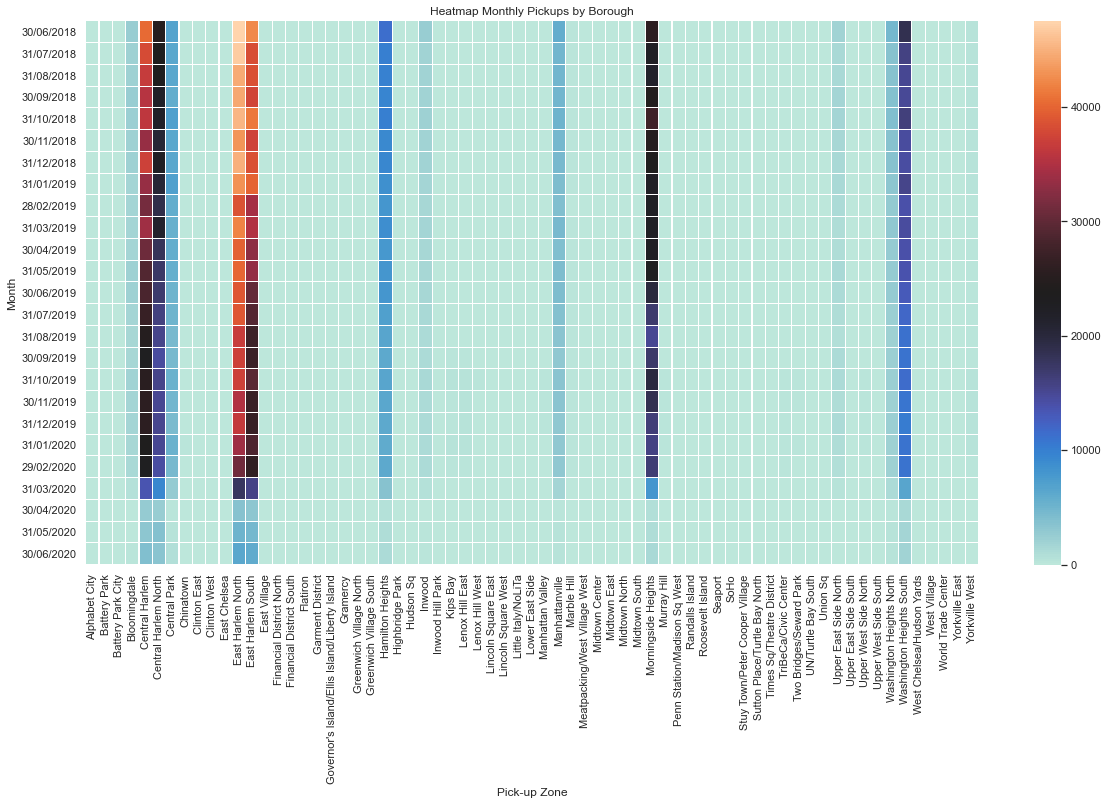

In [66]:
plt.figure(figsize=(20,10))
sns.heatmap(daily_pickups, linewidth=0.1, cmap="icefire")
plt.title('Heatmap Monthly Pickups by Borough')
plt.xlabel('Pick-up Zone')
plt.ylabel('Month')
plt.show()

#### Taxi Zone Drop-offs

In [67]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.pivot_table(index=pd.Grouper(key='lpep_dropoff_datetime', freq='M'),
                                         columns='Borough_dropoff', values='VendorID', aggfunc=np.count_nonzero)

daily_pickups.fillna(0, inplace=True)
daily_pickups.reset_index(inplace=True)
daily_pickups['lpep_dropoff_datetime'] = daily_pickups['lpep_dropoff_datetime'].dt.strftime('%d/%m/%Y')
daily_pickups.set_index('lpep_dropoff_datetime', inplace=True)

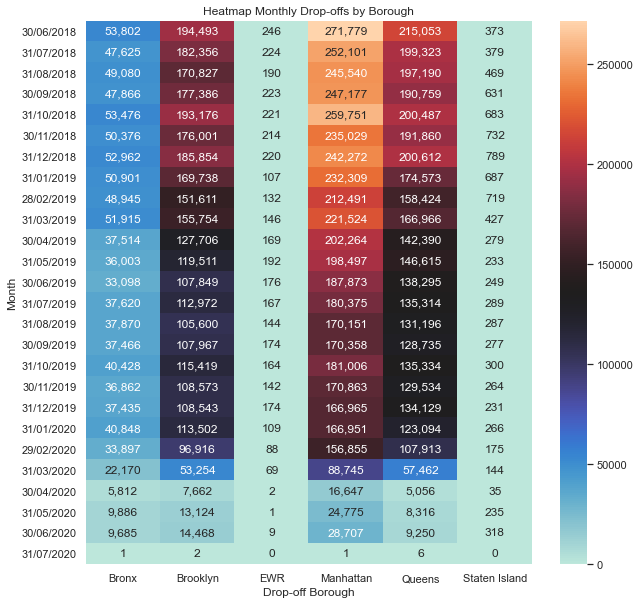

In [68]:
plt.figure(figsize=(10,10))
sns.heatmap(daily_pickups, annot=True, fmt=',.0f', cmap='icefire')
plt.title('Heatmap Monthly Drop-offs by Borough')
plt.xlabel('Drop-off Borough')
plt.ylabel('Month')
plt.show()

In [69]:
daily_pickups = df.loc[df['Borough_dropoff'] == 'Manhattan', ].copy()
daily_pickups = daily_pickups.pivot_table(index=pd.Grouper(key='lpep_dropoff_datetime', freq='M'),
                                         columns='Zone_dropoff', values='VendorID', aggfunc=np.count_nonzero)

daily_pickups.fillna(0, inplace=True)
daily_pickups.reset_index(inplace=True)
daily_pickups['lpep_dropoff_datetime'] = daily_pickups['lpep_dropoff_datetime'].dt.strftime('%d/%m/%Y')
daily_pickups.set_index('lpep_dropoff_datetime', inplace=True)

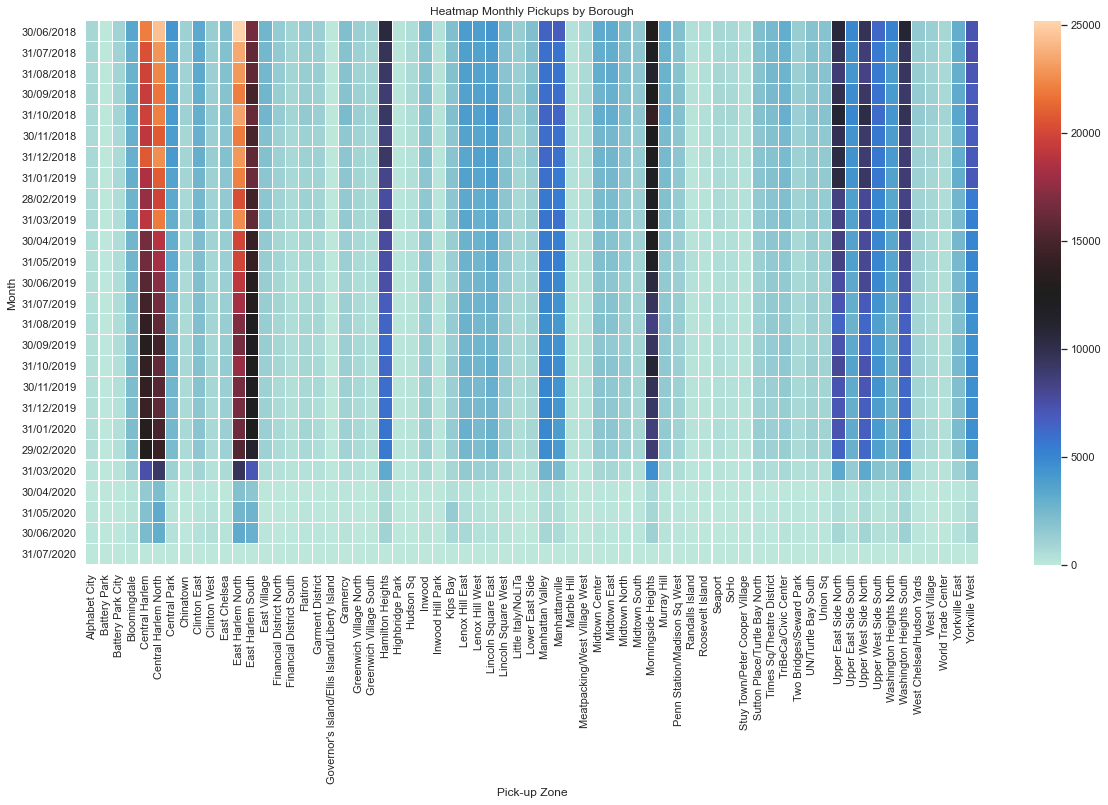

In [72]:
plt.figure(figsize=(20,10))
sns.heatmap(daily_pickups, linewidth=0.1, cmap="icefire")
plt.title('Heatmap Monthly Pickups by Borough')
plt.xlabel('Pick-up Zone')
plt.ylabel('Month')
plt.show()

### Taxi Zone Trip Flows

In [109]:
data = df.groupby(['Borough_x', 'Borough_dropoff',pd.Grouper(key='lpep_pickup_datetime', freq='D')]).agg({
    'VendorID': 'count'
})
trip_flow = data.pivot_table(index='Borough_x', columns='Borough_dropoff', values='VendorID', aggfunc=np.mean)
trip_flow.fillna(0, inplace=True)

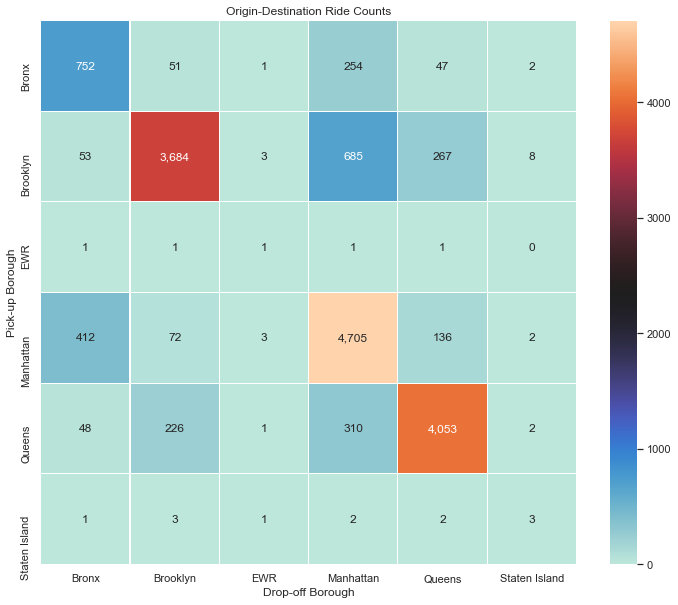

In [110]:
plt.figure(figsize=(12,10))
sns.heatmap(trip_flow, annot=True, linewidth=0.1,fmt=',.0f', cmap="icefire")
plt.title('Origin-Destination Ride Counts')
plt.xlabel('Drop-off Borough')
plt.ylabel('Pick-up Borough')
plt.show()

My brief literature review showed that most of the Direct Demand models use the average weekday ridership as the target for modelling public transit systems. As such, being that this model is regarding taxi useage, I decided that I would use average daily utilization as the feature to be plotted in the Trip Flow visualization above.

There are interesting little clusters which I find interesting. I also find it interesting that the most numerous daily taxi rides are within the same borough.

#### Fare Amount Choropleths

In [76]:
path = os.path.join(os.getcwd(), "map", 'taxi_zones.shp')
map_df = geopandas.read_file(path)

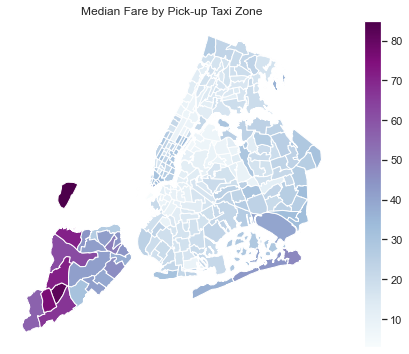

In [77]:
map_data = df.groupby('Zone_x').agg({'fare_amount': 'median'}).copy()
map_data = map_df.set_index('zone').join(map_data)
vmin = map_data.fare_amount.min()
vmax = map_data.fare_amount.max()
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig, ax = plt.subplots(1, figsize=(10,6))
map_data.plot(column='fare_amount', ax=ax, cmap='BuPu')
ax.axis('off')
cbar = fig.colorbar(sm)
plt.title('Median Fare by Pick-up Taxi Zone')
plt.show()

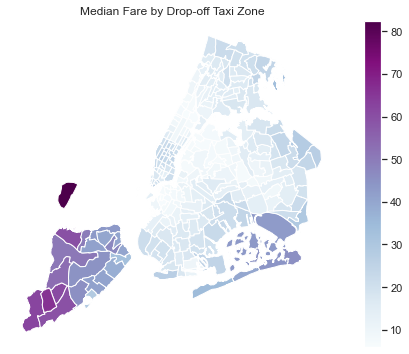

In [78]:
map_data = df.groupby('Zone_dropoff').agg({'fare_amount': 'median'}).copy()
map_data = map_df.set_index('zone').join(map_data)
vmin = map_data.fare_amount.min()
vmax = map_data.fare_amount.max()
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig, ax = plt.subplots(1, figsize=(10,6))
map_data.plot(column='fare_amount', ax=ax, cmap='BuPu')
ax.axis('off')
cbar = fig.colorbar(sm)
plt.title('Median Fare by Drop-off Taxi Zone')
plt.show()

## Question 5 - Communicating the Results

# Report on Passenger Trip Data Collection

## Trip Volume over Time

### Green Taxi Trends

Over the Twenty-Five months of data that was analysed there is a marked downward trend in the number of pick-ups and drop-offs in New York City. This is observed both in general and by Borough.

In [79]:
daily_pickups_total = df.copy()
daily_pickups_total = daily_pickups_total.groupby([pd.Grouper(key='lpep_pickup_datetime', freq='M'), 'Borough_x']).agg({
    'RatecodeID': 'count'
})

daily_dropoffs_total = df.copy()
daily_dropoffs_total = daily_dropoffs_total.groupby([pd.Grouper(key='lpep_dropoff_datetime', freq='M'), 'Borough_dropoff']).agg({
    'RatecodeID': 'count'
})


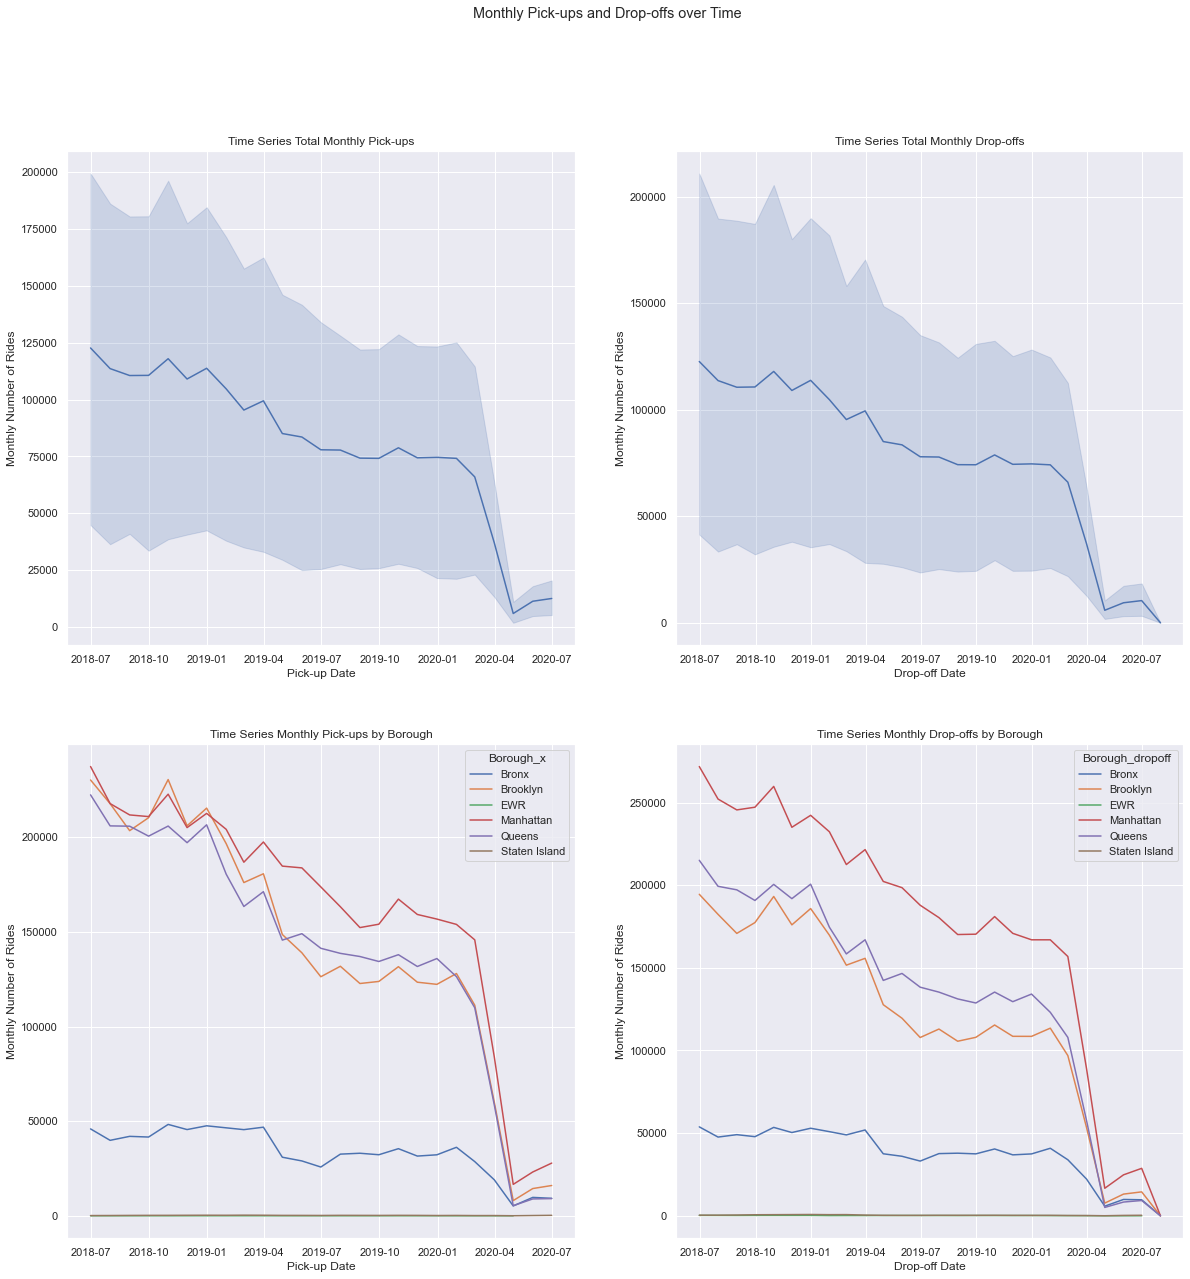

In [80]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Monthly Pick-ups and Drop-offs over Time')
ax1 = fig.add_subplot(221)
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=daily_pickups_total)
ax1.set_title('Time Series Total Monthly Pick-ups')
ax1.set_xlabel('Pick-up Date')
ax1.set_ylabel('Monthly Number of Rides')
ax2 = fig.add_subplot(222)
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=daily_dropoffs_total)
ax2.set_title('Time Series Total Monthly Drop-offs')
ax2.set_xlabel('Drop-off Date')
ax2.set_ylabel('Monthly Number of Rides')
ax3 = fig.add_subplot(223)
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=daily_pickups_total, hue='Borough_x')
ax3.set_title('Time Series Monthly Pick-ups by Borough')
ax3.set_xlabel('Pick-up Date')
ax3.set_ylabel('Monthly Number of Rides')
ax4 = fig.add_subplot(224)
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=daily_dropoffs_total, hue='Borough_dropoff')
ax4.set_title('Time Series Monthly Drop-offs by Borough')
ax4.set_xlabel('Drop-off Date')
ax4.set_ylabel('Monthly Number of Rides')
plt.show()

### Differences Between Vendors

The differences between vendors in this data set are also dramatic. Verifone Inc. is clearly the most represented in the data. There is a notable increase in trips which are missing Vendor data starting in July 2019 and continuing until the COVID-19 pandemic drove Taxi ride numbers down.

In [81]:
monthly_pickups_vendors = df.copy()
monthly_pickups_vendors = monthly_pickups_vendors.groupby([pd.Grouper(key='lpep_pickup_datetime', freq='M'), 'VendorID']).agg({
    'RatecodeID': 'count'
})
monthly_dropoffs_vendors = df.copy()
monthly_dropoffs_vendors = monthly_dropoffs_vendors.groupby([pd.Grouper(key='lpep_dropoff_datetime', freq='M'), 'VendorID']).agg({
    'RatecodeID': 'count'
})

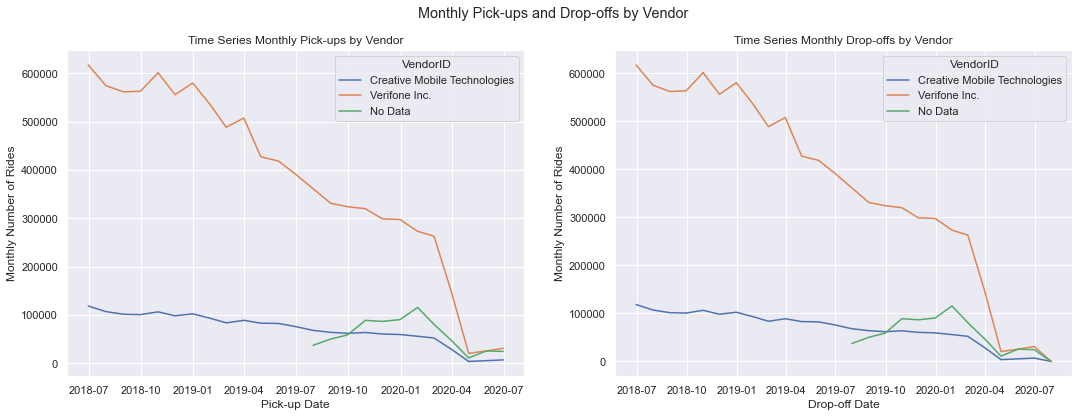

In [82]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('Monthly Pick-ups and Drop-offs by Vendor')
ax1 = fig.add_subplot(121)
sns.lineplot(x='lpep_pickup_datetime', y='RatecodeID', data=monthly_pickups_vendors, hue='VendorID')
ax1.set_title('Time Series Monthly Pick-ups by Vendor')
ax1.set_xlabel('Pick-up Date')
ax1.set_ylabel('Monthly Number of Rides')
ax2 = fig.add_subplot(122)
sns.lineplot(x='lpep_dropoff_datetime', y='RatecodeID', data=monthly_dropoffs_vendors, hue='VendorID')
ax2.set_title('Time Series Monthly Drop-offs by Vendor')
ax2.set_xlabel('Drop-off Date')
ax2.set_ylabel('Monthly Number of Rides')
plt.show()

### Effect of COVID-19 on Trip Volume

While the effect of COVID-19 on the trip volume of Taxies in New York City can be clearly seen in the above plots. It pretty clearly caused a dramatic decrease in the trip volume. Below is a plot which shows only the March through June of each year plotted against eachother.

In [91]:
daily_pickups = df.copy()
daily_pickups['year'] = pd.DatetimeIndex(daily_pickups['lpep_pickup_datetime']).year
daily_pickups['month'] = pd.DatetimeIndex(daily_pickups['lpep_pickup_datetime']).month
daily_pickups = daily_pickups.groupby(['year', 'month']).agg({
    'VendorID': 'count'
}).groupby('year').agg({'VendorID': 'mean'})
daily_pickups.rename(columns={'VendorID': 'Average Pick-ups per Month'}, inplace=True)
daily_pickups
                                            

,Average Pick-ups per Month
year,
2018,684295.857143
2019,499958.583333
2020,202716.500000


In [90]:
daily_dropoffs = df.copy()

daily_dropoffs['year'] = pd.DatetimeIndex(daily_dropoffs['lpep_dropoff_datetime']).year
daily_dropoffs['month'] = pd.DatetimeIndex(daily_dropoffs['lpep_dropoff_datetime']).month
daily_dropoffs = daily_dropoffs.groupby(['year', 'month']).agg({
    'VendorID': 'count'
}).groupby('year').agg({'VendorID': 'mean'})
daily_dropoffs.rename(columns={'VendorID': 'Average Drop-offs per Month'}, inplace=True)
daily_dropoffs


,Average Drop-offs per Month
year,
2018,684258.142857
2019,499967.500000
2020,173779.428571


As you can see from these two tables the average number of trips per month changed drastically between 2019 and 2020. The average number of pick-ups 

### Trip Volume by Geographic Region

#### Pick-up and Drop-off by region


In [94]:
daily_pickups = df.copy()
daily_pickups = daily_pickups.pivot_table(index=pd.Grouper(key='lpep_pickup_datetime', freq='M'),
                                         columns='Borough_x', values='VendorID', aggfunc=np.count_nonzero)

daily_pickups.fillna(0, inplace=True)
daily_pickups.reset_index(inplace=True)
daily_pickups['lpep_pickup_datetime'] = daily_pickups['lpep_pickup_datetime'].dt.strftime('%d/%m/%Y')
daily_pickups.set_index('lpep_pickup_datetime', inplace=True)

daily_dropoff = df.copy()
daily_dropoff = daily_dropoff.pivot_table(index=pd.Grouper(key='lpep_dropoff_datetime', freq='M'),
                                         columns='Borough_dropoff', values='VendorID', aggfunc=np.count_nonzero)

daily_dropoff.fillna(0, inplace=True)
daily_dropoff.reset_index(inplace=True)
daily_dropoff['lpep_dropoff_datetime'] = daily_dropoff['lpep_dropoff_datetime'].dt.strftime('%d/%m/%Y')
daily_dropoff.set_index('lpep_dropoff_datetime', inplace=True)

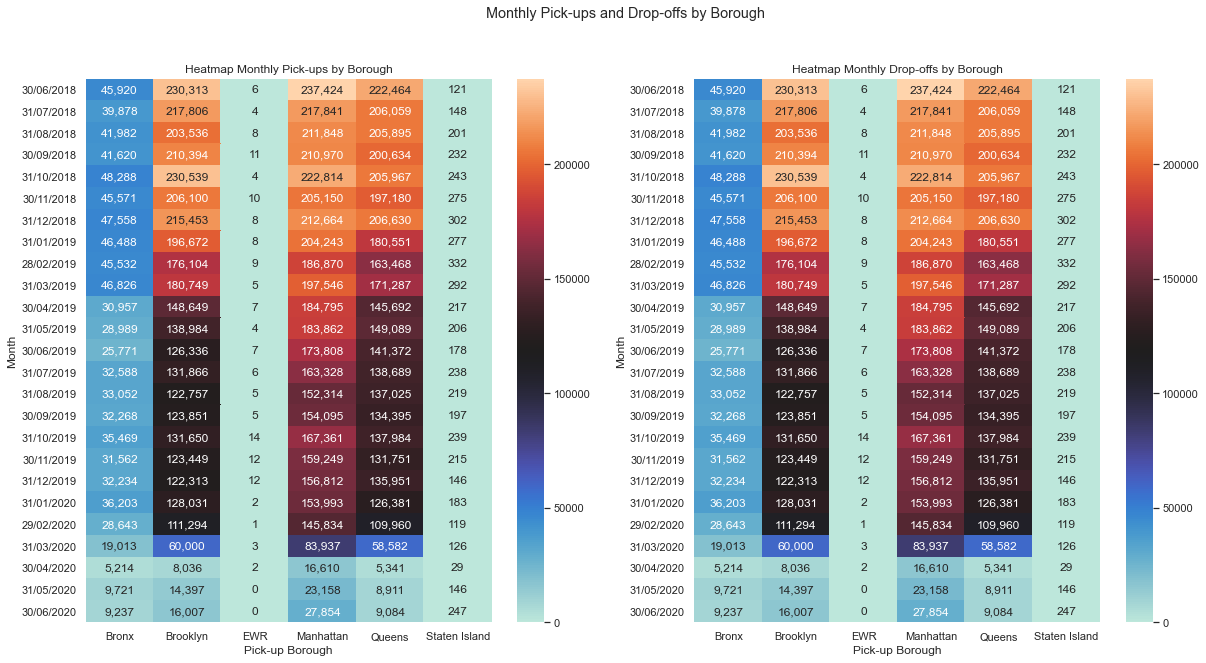

In [98]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Monthly Pick-ups and Drop-offs by Borough')
ax1 = fig.add_subplot(121)
sns.heatmap(daily_pickups, annot=True, fmt=',.0f', cmap='icefire')
ax1.set_title('Heatmap Monthly Pick-ups by Borough')
ax1.set_xlabel('Pick-up Borough')
ax1.set_ylabel('Month')

ax2 = fig.add_subplot(122)
sns.heatmap(daily_pickups, annot=True, fmt=',.0f', cmap='icefire')
ax2.set_title('Heatmap Monthly Drop-offs by Borough')
ax2.set_xlabel('Pick-up Borough')
ax2.set_ylabel('Month')
plt.show()

These two heatmaps show the average number of pick-ups and drop-offs separated by pick-up and drop-off borough. It is quite clear that there are three boroughs which make up the bulk of the trips in New York City; those being Brooklyn, Manhattan, and Queens with the Bronx being a reasonably distant fourth.

#### Seasonality

There doesn't appear to be a significant seasonal component in the trips by borough. It seems to me that the apparent oscilation in ride numbers that can be observed in the sesonality decomposition of each burough could be attributed to random variance.

### Trip Data Quality

#### Categorical Features

Among the Categorical Features the primary issues are the amount of missing data. I marked these in the data with 'No Data', and found that there are enough "No Data" records in the VendorID data to make it a good competitor for Creative Mobile Technologies starting in August 2019.

#### Date Features

There were a few records whose pick-up and drop-off dates and times were outside of the stated range of the datasets with some years as low as 2008 and as high as 2035. I removed these from the dataset because there wasn't a way to place them correctly within the range

#### Numeric Features

There were a number of out of expected range numeric features as well. Negative Trip distances were replaced by the median distance between the stated endpoints. I applied similar methods with the fare_amount, and in further modelling would likely apply the same technique to the total_amount, and tip_amount. I also found that there are a significant number of zero-value trip distances, and fare_amounts as well. For the fare amounts, I expected that the Disputed and No Charge payment types would represent the majority of the negative values. However, all payment types have negative values in them.

### Downstream Analysis

Based on the available data, and my literature review, I think that it would be possible to use ML methods and/or forecasting methods to accurately predict taxi demand. I am going to provide a small caveat, in that it would depend on the degree of accuracy that is desired. There are a few papers which describe various applications of Linear Regressors for this type of modelling, and I found one paper which suggested a Generalized Regressor Neural Network. I would likely start with a Generalized Linear Regressor. The literature suggests that distance and time are features that have predictive merit when modelling transportation utilization. So I would create a feature which is the time delta between origin and destination. I would also create dummy variables for each of the target regions in both a pick-up and drop-off state, so that the origin and destination can be flagged. I think that the average fare_cost for each origin could act as a proxy feature for other socio-economic features. Other features would likely need to be brought in from other datasets. It would be helpful to have population, and attactor density measures for each of the target regions. As for further data quality considerations, the distances, and fare data would need to better regularized. Any outside data would need to be merged into the existing dataset. It would probably be best to dedicate time to feature selection, and parameter tuning. But I would be interested to see how accurate the model could be.

## Resources Used


### Library Documentation
* https://pandas.pydata.org/docs/user_guide/index.html#user-guide
* https://geopandas.org/mapping.html
* https://seaborn.pydata.org/tutorial.html
* https://docs.python.org/3/library/urllib.request.html#module-urllib.request

### Specific function documentation
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL
* https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Stackoverflow Questions and Other Solutions
* https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
* https://stackoverflow.com/questions/3451111/unzipping-files-in-python
* https://stackoverflow.com/questions/27019153/how-to-scale-seaborns-y-axis-with-a-bar-plot
* https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
* https://kanoki.org/2020/05/26/dataframe-groupby-date-and-time/
* https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib
* https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/subset-time-series-data-python/
*https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

### Papers
* https://www.researchgate.net/publication/304143375_Updating_origin-destination_matrices_with_aggregated_data_of_GPS_traces
* https://www.sciencedirect.com/science/article/abs/pii/S0965997806001153
* https://tigerprints.clemson.edu/cgi/viewcontent.cgi?article=4041&context=all_theses